In [1]:
from numba import jit, cuda
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import winsound as sd
def beepsound():
    fr = 1000    # range : 37 ~ 32767
    du = 500     # 1000 ms ==1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)

In [3]:
df =  pd.read_csv('ClusterMain.csv', header=0)

In [4]:
df = df.dropna()

In [5]:
#df = df.loc[df['임대건물명'] == '아파트'].dropna()
#다세대/연립
#단독/다가구
#아파트
#오피스텔

<AxesSubplot:>

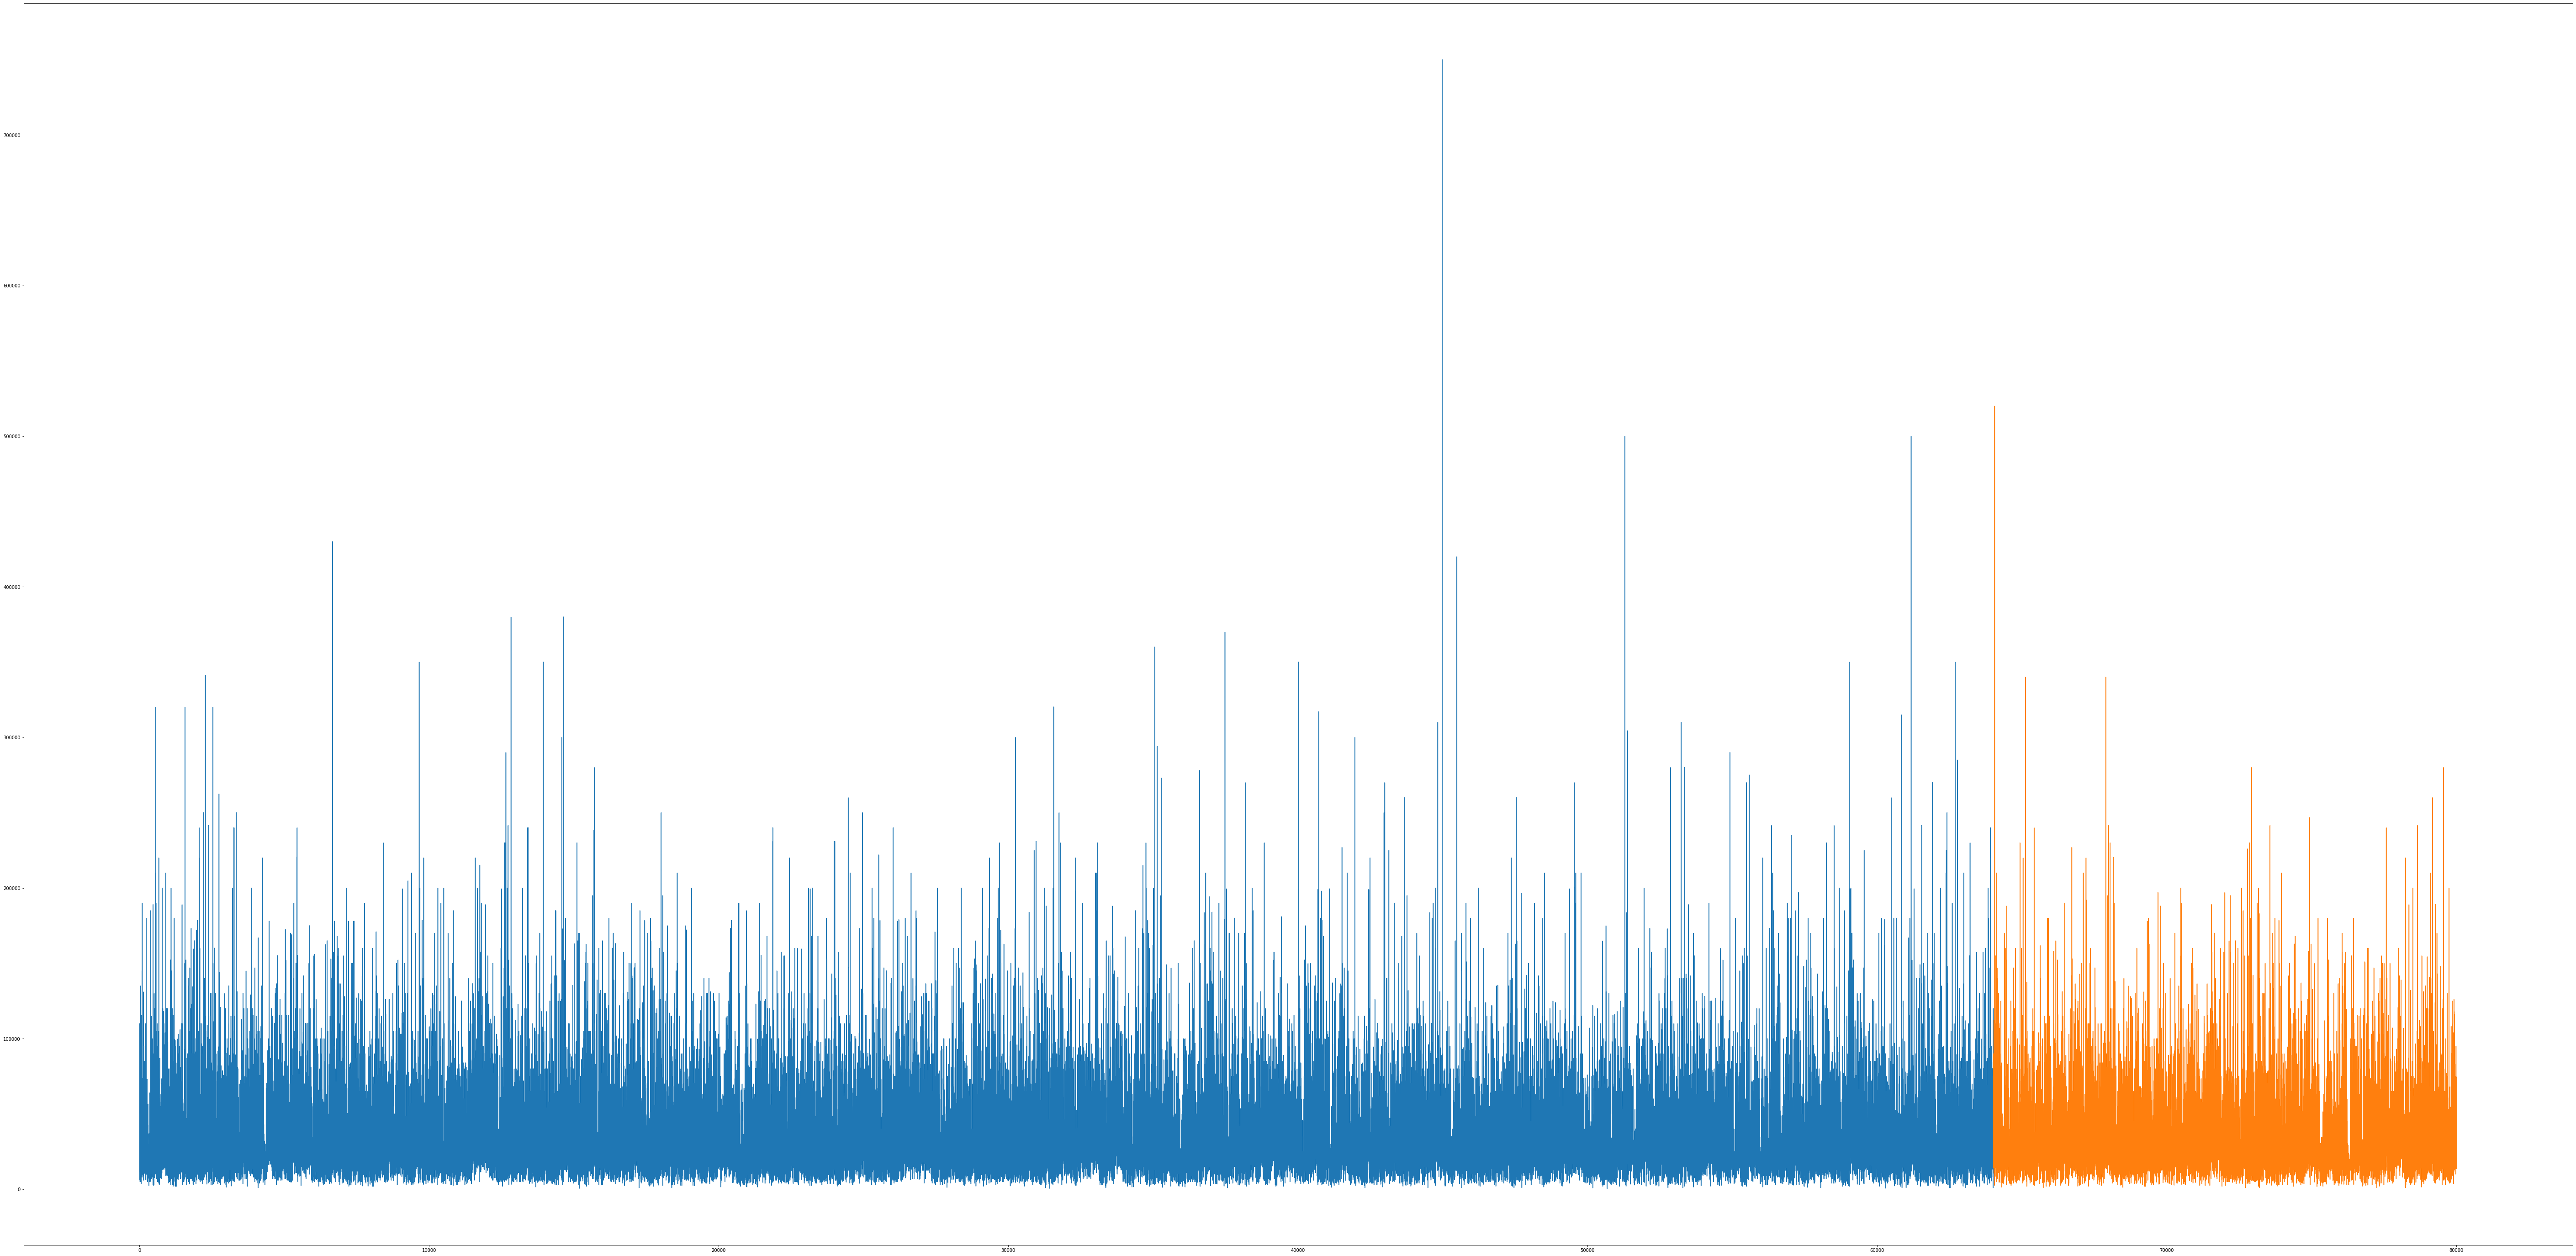

In [6]:
y_train = df['보증금'][:int(0.8*len(df))]
y_test = df['보증금'][int(0.8*len(df)):]
plt.figure(figsize=(100,50))
y_train.plot()
y_test.plot()

In [7]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [8]:
model = pm.auto_arima(y = y_train      
                      , d = 1         
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = True 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1536037.618, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1516338.050, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1493621.727, Time=3.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1536035.618, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1493605.003, Time=5.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1493592.038, Time=7.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1508158.073, Time=1.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1493553.102, Time=11.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1504199.212, Time=2.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1492853.822, Time=8.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1492875.789, Time=6.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1492719.207, Time=14.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1492719.258, Time=10.55 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1492717.207, Ti

In [9]:
model.fit(y_train)

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [10]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                64016
Model:               SARIMAX(3, 1, 3)   Log Likelihood             -746351.603
Date:                Fri, 10 Jun 2022   AIC                        1492717.207
Time:                        20:08:51   BIC                        1492780.675
Sample:                             0   HQIC                       1492736.862
                              - 64016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0882      0.117     -9.340      0.000      -1.317      -0.860
ar.L2         -0.8467      0.117     -7.230      0.000      -1.076      -0.617
ar.L3         -0.0075      0.006     -1.345      0.1

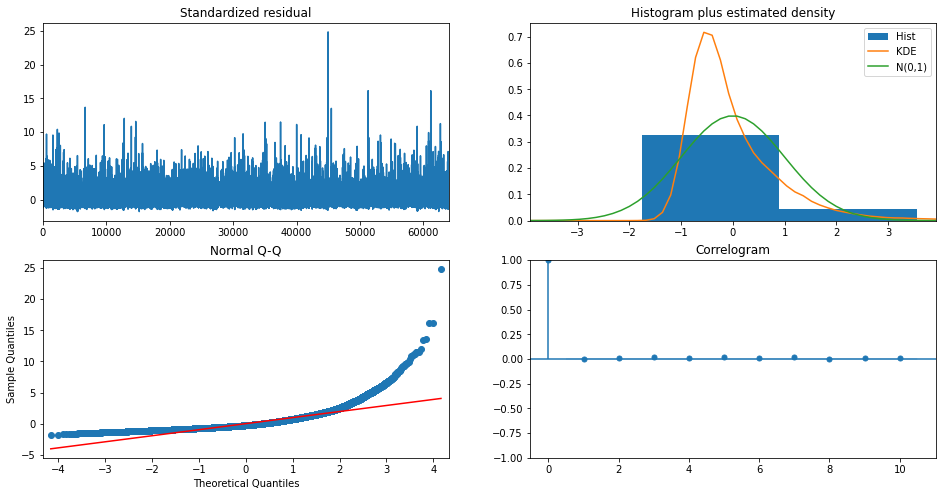

In [11]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

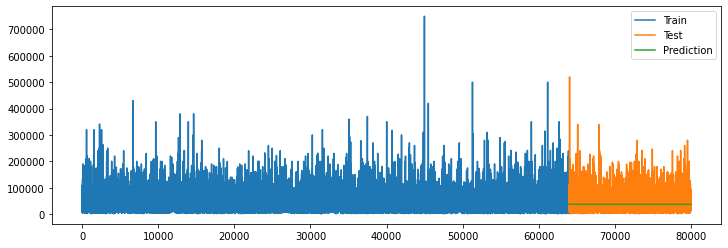

In [12]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [13]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [15]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

i=0

print(len(y_test))

for new_ob in y_test:
    
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

    if i%100==0:
        print(i)

    i = i+1

beepsound()

16005
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000


In [52]:
a = pd.DataFrame({"test": y_test, "pred": y_pred, "pred_upper" : pred_upper, "pred_lower" : pred_lower})

In [51]:
len(forecasts)

0

In [ ]:
#forecasts = []
#y_pred = []
#pred_upper = []
#pred_lower = []

In [53]:
a.to_csv("ArimaResult.csv",encoding='cp949')

In [34]:
a = pd.read_csv('ArimaResult.csv',encoding='cp949')

In [35]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                80021
Model:               SARIMAX(3, 1, 3)   Log Likelihood             -932033.314
Date:                Sat, 11 Jun 2022   AIC                        1864080.628
Time:                        10:08:18   BIC                        1864145.658
Sample:                             0   HQIC                       1864100.563
                              - 80021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0613      0.005    -11.571      0.000      -0.072      -0.051
ar.L2          0.9666      0.003    340.212      0.000       0.961       0.972
ar.L3          0.0284      0.004      7.238      0.0

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=1080, width=1920, title_text="ARIMA(3,1,3)모형")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [19]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")

MAPE: 90.394


In [20]:
from sklearn import metrics

print("MAE : " + str(metrics.mean_absolute_error(y_test, y_pred)))
print("MSE : " + str(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : " + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print("R^2 : " + str(metrics.r2_score(y_test,y_pred)))

MAE : 18371.069572960383
MSE : 713799004.7331016
RMSE : 26717.017137642848
R^2 : 0.023140195365792482
